## DBSCAN 
Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is a density based unsupervised machine learning model that defines _clusters as continuous regions of high density_

___How it works:___  


- For each instance the algorithm counts how many instances are around it within $\epsilon$    distance.

- If number of instances in $\epsilon$ distance is atleast `min_samples`, then that instance is called ___core instance___   
Core instance are those that are located in a dense region

- The instances in neighbourhood of core instances belong to same cluster. The neighbourhood may have more than one core instances, hence a long sequence of core instances form a _cluster_

- Any instance that is not a core instance and does not have any core instance in its neighbourhood is considered as _anomaly_

This algo works well if clusters are dense enough and their separation is well defined by low density regions

In [2]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

In [112]:
X,y = make_moons(n_samples=2000,noise=0.08,random_state=42)
X.shape, y.shape

((2000, 2), (2000,))

Text(0, 0.5, 'X2')

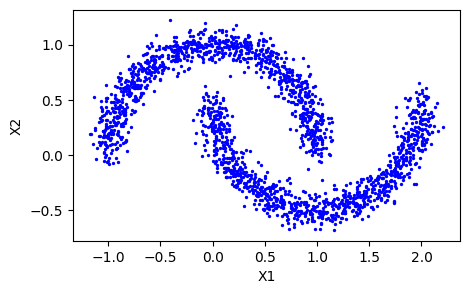

In [113]:
plt.figure(figsize=(5,3))
plt.scatter(X[:,0],X[:,1],c='b',s=2)
plt.xlabel("X1")
plt.ylabel("X2")

### Check with KMeans first

In [114]:
from sklearn.cluster import KMeans
kmeans= KMeans(n_clusters=2,init='k-means++',n_init=3)
kmeans.fit(X)
x_pred = kmeans.predict(X)

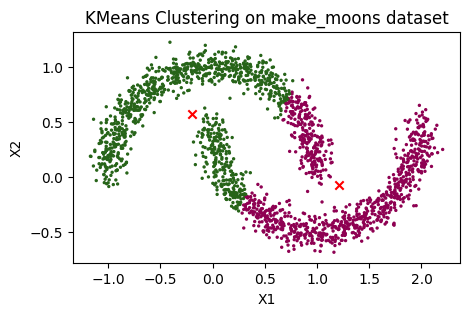

In [115]:
plt.figure(figsize=(5,3))
cluster_center = kmeans.cluster_centers_
plt.scatter(cluster_center[:,0],cluster_center[:,1],c='r',marker="x")
plt.scatter(X[:,0], X[:,1], c=x_pred, cmap='PiYG', s=2)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("KMeans Clustering on make_moons dataset")
plt.show()

uh-ohh...  
The problem is that, kmeans thinks clusters are spherical

### With DBSCAN

In [178]:
dbscan = DBSCAN(eps=0.1,min_samples=5)
dbscan.fit(X)

,eps,0.1
,min_samples,5
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


core instances index

In [179]:
dbscan.core_sample_indices_

array([   0,    1,    2, ..., 1997, 1998, 1999], shape=(1970,))

core instances

In [180]:
components = dbscan.components_
components

array([[ 1.80240073,  0.16953549],
       [ 0.40716275,  0.92346003],
       [ 0.49624635, -0.32786214],
       ...,
       [-0.93039036,  0.5070836 ],
       [ 0.84616265, -0.59918561],
       [ 0.13697226,  0.09766031]], shape=(1970, 2))

Labels

In [181]:
labels = dbscan.labels_
labels

array([0, 1, 0, ..., 1, 0, 0], shape=(2000,))

labels that are "-1" are considered as anomalies

In [182]:
(dbscan.labels_ == -1).sum()

np.int64(5)

Comparing two different neighbourhood radius

In [183]:
dbscan1 = DBSCAN(eps=0.05,min_samples=5)
dbscan1.fit(X)

dbscan2 = DBSCAN(eps=0.1,min_samples=5)
dbscan2.fit(X)

,eps,0.1
,min_samples,5
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


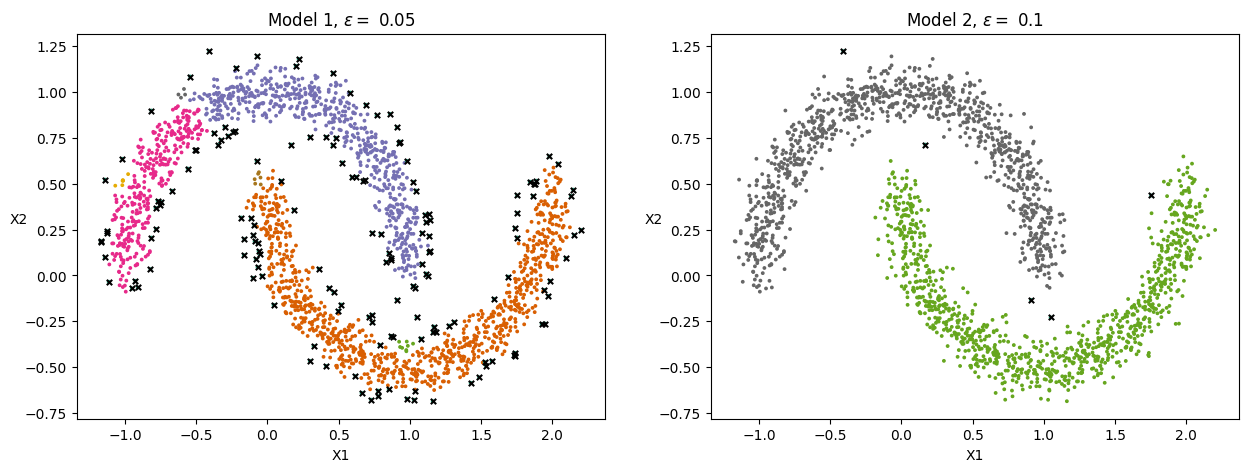

In [184]:
## plotting dbscan clusters
plt.figure(figsize=(15,5))

for idx,model in enumerate([dbscan1,dbscan2]):
    plt.subplot(1,2,1+idx)
    plt.title(fr"Model {idx+1}, $\epsilon=$ {model.eps}")
    plt.scatter(X[:,0],X[:,1],c=model.labels_,cmap='Dark2',s=3)
    anomalies_idx = (model.labels_==-1)
    anomalies = X[anomalies_idx]
    plt.scatter(anomalies[:,0],anomalies[:,1],marker="x",s=15,c='k')
    plt.xlabel("X1")
    plt.ylabel("X2",rotation=0)

We can see that there are 7 clusters in first model and 3 in second model

Note :   
The DBSCAN algo does not provide `predict()` function, but provides `fit_predict()` function. WHY?  
- This is because, unlike kmeans where we can assign any new instance to nearest center, dbscan consider clusters as irrgular blobs and any new instance have 3 choices to fall 
    - In dense region - inside cluster
    - In sparse area - considered as outlier
    - on boundary - classification is not clear    
It is upto us on how we want final prediction to be based on


- DBSCAN doesnt provide _predict_ because it cannot predict in which cluster a new instance belongs to
- It provides _fit_predict_, it can cluster the given data and return labels

__Then how we implement _predict_ function?__   
By using any other supervised learning model   
- Run DBSCAN 
- Get labels 
- Train supervised model on those labels 

In [207]:
## For example
from sklearn.svm import SVC
svc = SVC()

#Training svc on core instances only
svc.fit(X=dbscan.components_,y=dbscan.labels_[dbscan.core_sample_indices_])

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [208]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
svc.predict(X_new)

array([0, 0, 1, 0])

We can use:  
1. Core instance or
2. All isntances except anomalies  
To train the model

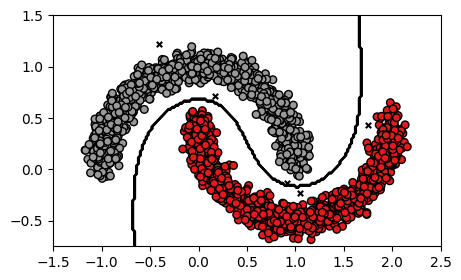

In [213]:
plt.figure(figsize=(5,3))
def plot_decision_boundary(clf, X, y, resolution=0.02):
    # grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # prediction on grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # only boundary lines
    plt.contour(xx, yy, Z, colors='k', linewidths=1)

    # plot points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, s=30, edgecolor="k")
    plt.show()

anomalies_idx = (dbscan.labels_==-1)
anomalies = X[anomalies_idx]
plt.scatter(anomalies[:,0],anomalies[:,1],marker="x",s=15,c='k')
plt.axis([-1.5,2.5,-0.75,1.5])
plot_decision_boundary(svc,dbscan.components_,dbscan.labels_[dbscan.core_sample_indices_])

In short, DBSCAN is a very simple yet powerful algorithm capable of identifying any
number of clusters of any shape. It is robust to outliers, and it has just two hyperpara‐
meters (eps and min_samples).

Its computational complexity is roughly $O(\text{m logm})$, making it pretty close to linear with regard to the number of instances, but Scikit-Learn’s implementation can require up to
$O\text{(m2)}$ memory if eps is large.